In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [ ]:
#Data Ingestion

import pandas as pd


#Raw CSV links - this link changes often in Github and will need to updated frequently
transactions_csv_url  = 'https://raw.githubusercontent.com/daned1360/XGBoost_NewHome_PriceModel/refs/heads/main/ZondaTransactions.csv'
floorplans_csv_url    = 'https://raw.githubusercontent.com/daned1360/XGBoost_NewHome_PriceModel/refs/heads/main/ZondaNew_Floorplans.csv'
projects_csv_url      = 'https://raw.githubusercontent.com/daned1360/XGBoost_NewHome_PriceModel/refs/heads/main/ZondaNew_Projects.csv'

#Pandas Data Frames
transactions_df = pd.read_csv(transactions_csv_url)
floorplans_df = pd.read_csv(floorplans_csv_url)
projects_df = pd.read_csv(projects_csv_url)

In [ ]:
columns_to_keep = ['Lot Size'
                  , 'Unit Size'
                  , 'Bedrooms'
                  , 'Bathrooms'
                  , 'Year Built'
                  , 'New Construction'
                  , 'Sale Date', 'Sale Price'
                  , 'Latitude'
                  , 'Longitude']

transactions_df_trim = transactions_df[columns_to_keep]

#print(transactions_df_trim.dtypes)

In [ ]:
# Ensure we have a copy, not a view
transactions_df_trim = transactions_df_trim.copy()

# Convert 'Sale Date' to datetime (force pandas dtype)
transactions_df_trim['Sale Date'] = pd.to_datetime(
    transactions_df_trim['Sale Date'], errors='coerce'
)

# Confirm it's a proper pandas Series
if isinstance(transactions_df_trim['Sale Date'], np.ndarray):
    transactions_df_trim['Sale Date'] = pd.Series(
        transactions_df_trim['Sale Date'], index=transactions_df_trim.index
    )

# Calculate days since the minimum Sale Date
min_date = transactions_df_trim['Sale Date'].min()
transactions_df_trim['Days Since Min Date'] = (
    transactions_df_trim['Sale Date'] - min_date
).dt.days

# Drop the original Sale Date column
transactions_df_trim = transactions_df_trim.drop(columns=['Sale Date'])

# Convert boolean columns to integers
transactions_df_trim['New Construction'] = transactions_df_trim['New Construction'].astype(int)

# Remove rows with NA values
transactions_df_trim = transactions_df_trim.dropna()

# Display the modified DataFrame
#print(transactions_df_trim)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define features (X) and target (y)
X = transactions_df_trim.drop(columns=['Sale Price'])
y = transactions_df_trim['Sale Price']

# Create the pipeline
pipeline = make_pipeline(StandardScaler(), XGBRegressor(objective='reg:squarederror'))

# Set up the parameter grid for hyperparameter tuning (XGBoost)
#param_grid = {
#    'xgbregressor__n_estimators': [100, 200, 300],
#    'xgbregressor__max_depth': [3, 5, 7],
#    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
#    'xgbregressor__subsample': [0.8, 1.0],
#    'xgbregressor__colsample_bytree': [0.8, 1.0],
#    'xgbregressor__reg_lambda': [1, 10],
#    'xgbregressor__random_state': [42],
#}

param_grid_refined = {
    'xgbregressor__n_estimators': [250, 300, 350, 400],          # around 300
    'xgbregressor__max_depth': [4, 5, 6],                        # around 5
    'xgbregressor__learning_rate': [0.05, 0.1, 0.15],            # around 0.1
    'xgbregressor__subsample': [0.8, 0.9, 1.0],                  # around 1.0
    'xgbregressor__colsample_bytree': [0.7, 0.8, 0.9],           # around 0.8
    'xgbregressor__reg_lambda': [5, 10, 20],                     # around 10
    'xgbregressor__reg_alpha': [0, 0.1, 0.5],                    # optional L1 regularization
    'xgbregressor__gamma': [0, 0.1, 0.2],                        # minimum loss reduction
    'xgbregressor__random_state': [42]
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X, y)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (MSE):", -grid_search.best_score_)


Best parameters: {'xgbregressor__colsample_bytree': 0.8, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 300, 'xgbregressor__random_state': 42, 'xgbregressor__reg_lambda': 10, 'xgbregressor__subsample': 1.0}
Best cross-validation score (MSE): 34531556680.936874


Mean Squared Error: 17984932166.38803
Mean Absolute Error: 75755.76725031229
Median Absolute Error: 46441.5


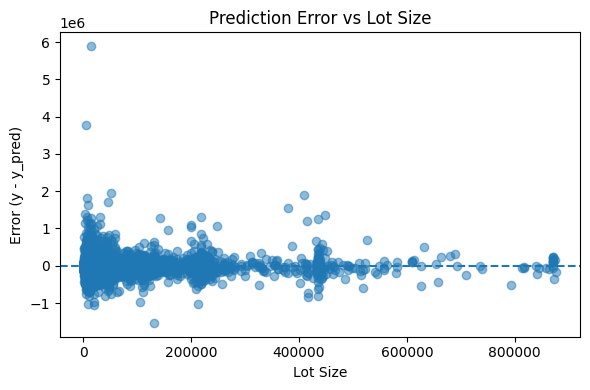

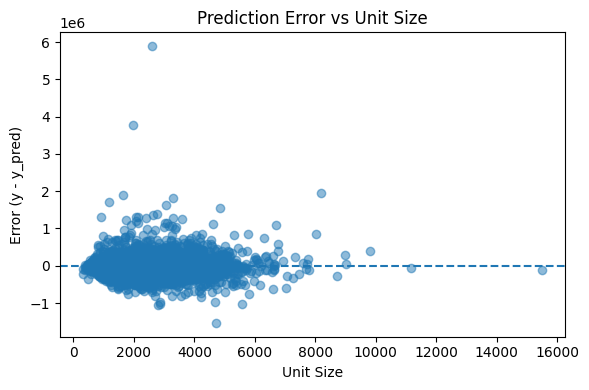

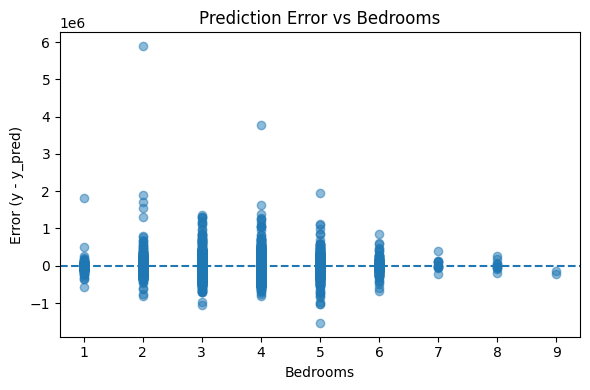

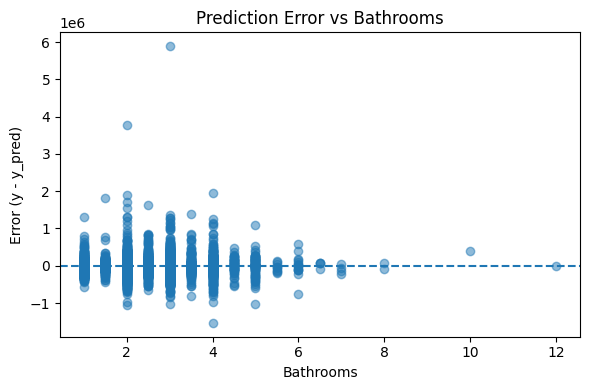

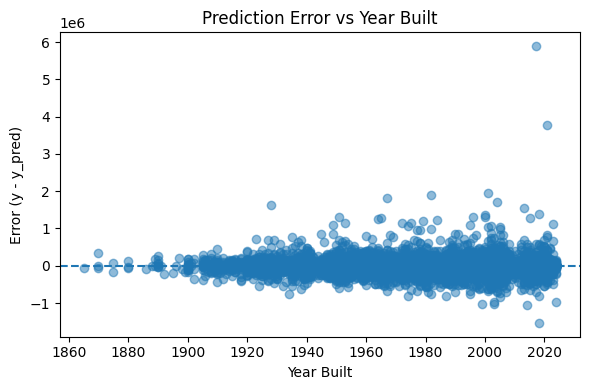

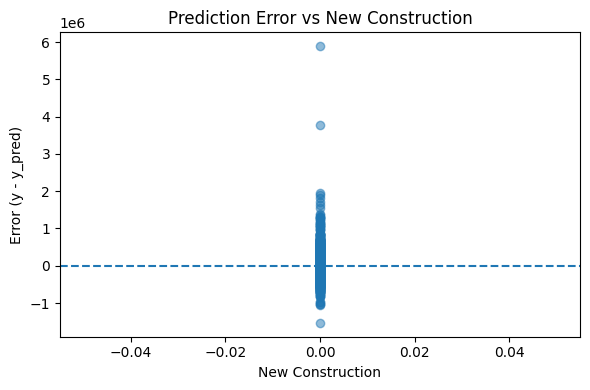

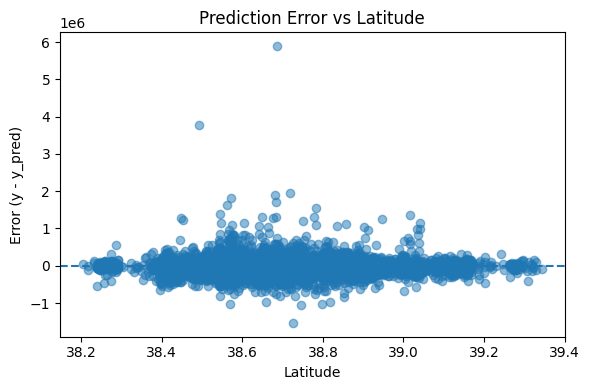

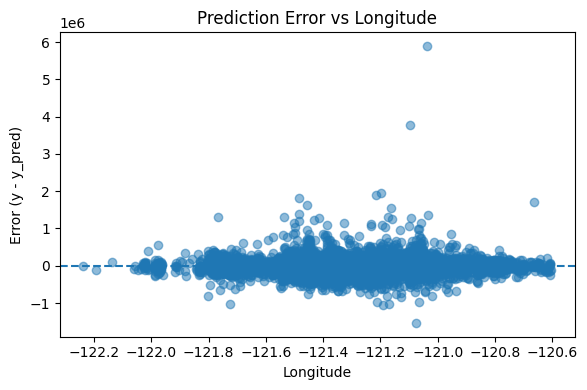

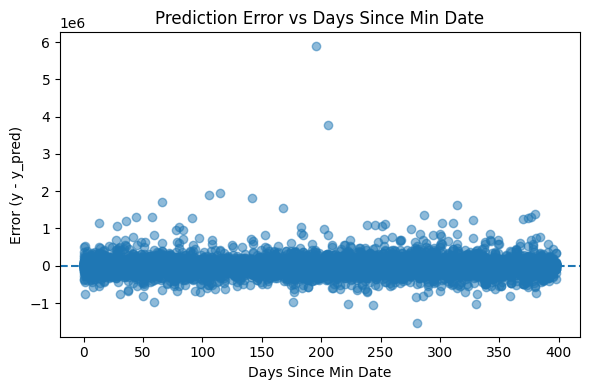


Top feature importances:


,Feature,Importance
0,Unit Size,0.419992
1,Bathrooms,0.171974
2,Bedrooms,0.118032
3,Lot Size,0.090716
4,Year Built,0.063782
5,Latitude,0.061899
6,Longitude,0.056473
7,Days Since Min Date,0.017132
8,New Construction,0.000000


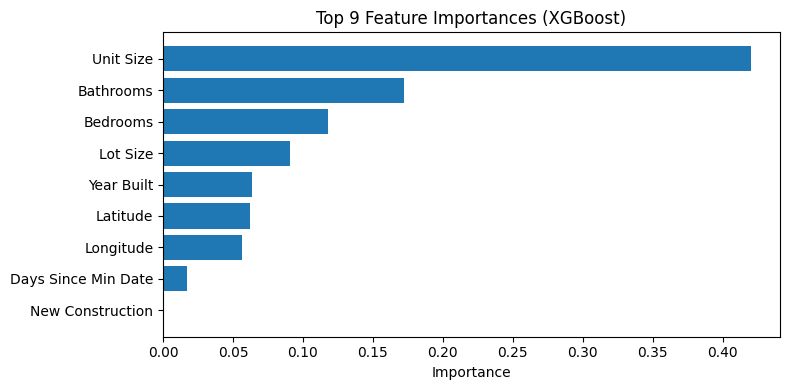

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

# Best model from grid search
best_model_resale = grid_search.best_estimator_

# Predictions and global metrics
y_pred = best_model_resale.predict(X)
errors = y - y_pred
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
medae = median_absolute_error(y, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Median Absolute Error:", medae)

# Ensure X is a DataFrame (it should be already)
X_df = X.copy()

# Scatter plots: one figure per numeric feature vs error
for col in X_df.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(X_df[col], errors, alpha=0.5)
    plt.axhline(0, linestyle='--')
    plt.title(f"Prediction Error vs {col}")
    plt.xlabel(col)
    plt.ylabel("Error (y - y_pred)")
    plt.tight_layout()
    plt.show()

# Feature importance from the fitted XGBoost inside the pipeline
xgb_model = best_model_resale.named_steps['xgbregressor']
fi = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_df.columns,
    'Importance': fi
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\nTop feature importances:")
display(importance_df.head(15))

# Plot top 15 importances (horizontal bar)
top_n = min(15, len(importance_df))
plt.figure(figsize=(8, max(4, top_n * 0.35)))
plt.barh(importance_df['Feature'].head(top_n)[::-1], importance_df['Importance'].head(top_n)[::-1])
plt.title(f"Top {top_n} Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
#Fix Incentive Data

#QMI Incentive
#Fill in incentives from %'s to $'s
projects_df['QMI Incentive Amt.'] = projects_df['QMI Incentive Amt.'].fillna((projects_df['QMI Incentive %age'] / 100) * projects_df['Avg. List Price'])

# Fill any missing values in $_incentive with $0
projects_df['QMI Incentive Amt.'] = projects_df['QMI Incentive Amt.'].fillna(0)

#BTO Incentive
#Fill in incentives from %'s to $'s
projects_df['To Be Built Incentive Amt.'] = projects_df['To Be Built Incentive Amt.'].fillna((projects_df['To Be Built Incentive %age'] / 100) * projects_df['Avg. List Price'])

# Fill any missing values in $_incentive with $0
projects_df['To Be Built Incentive Amt.'] = projects_df['To Be Built Incentive Amt.'].fillna(0)

#Broker Incentive
#Fill in incentives from %'s to $'s
projects_df['Broker Incentive %age'] = projects_df['Broker Incentive %age'].fillna(projects_df['Broker Incentive Amt.']/projects_df['Avg. List Price'])

# Fill any missing values in $_incentive with $0
projects_df['Broker Incentive %age'] = projects_df['Broker Incentive %age'].fillna(.02)



In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

#Wangling Zonda

#Drop duplicate columns from the project DataFrame
# Find columns that are present in both DataFrames
columns_to_keep = ['Universal ID', 'Lot Size', 'Sales Rate', 'HOA Fee 1', 'Assessments', 'QMI Incentive Amt.', 'To Be Built Incentive Amt.', 'Broker Incentive %age']
# Drop the duplicate columns, keeping only the columns from the left DataFrame
projects_df_trim = projects_df[columns_to_keep]

#combine floorplans and project data
newhome_df = pd.merge(floorplans_df, projects_df_trim, left_on='Project Universal ID', right_on='Universal ID')
newhome_df = newhome_df.drop(columns = ['Parent Builder', 'Status', 'City', 'State', 'County', 'CBSA', 'Plan Name', 'Last Update Date', 'Plan Universal ID'
                                    , 'County Code', 'CBSA Code', 'Project Universal ID', 'Universal ID', 'ZIP Code', 'Master Plan Name', 'Master Plan Developer Name', 'Active Adult',
                                        'Boundary Names'])

#add columns for "Year Built", "Sale Date" and "New Construction"
newhome_df['Year Built'] = datetime.now().year
newhome_df['New Construction'] = True
newhome_df['Days Since Min Date'] = transactions_df_trim['Days Since Min Date'].max()

#remove rows with lot size = 0
#newhome_df = newhome_df[newhome_df['Lot Size'] > 0]

#floorplans columns
#print(newhome_df.dtypes) #object = text

In [ ]:
# Make predictions using the best model
columns_to_keep = ['Lot Size'
                  , 'Unit Size'
                  , 'Bedrooms'
                  , 'Bathrooms'
                  , 'Year Built'
                  , 'New Construction'
                  , 'Latitude'
                  , 'Longitude'
                  , 'Days Since Min Date']

predictions = best_model_resale.predict(newhome_df[columns_to_keep])

newhome_df['Transaction_Prediction'] = predictions

#print(newhome_df)

In [ ]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

newhome_df_trim = newhome_df.dropna(subset=['Transaction_Prediction'])
newhome_df_trim = newhome_df_trim.dropna(subset=['List Price'])

# Predict and evaluate
mse = mean_squared_error(newhome_df_trim['List Price'], newhome_df_trim['Transaction_Prediction'])
mae = mean_absolute_error(newhome_df_trim['List Price'], newhome_df_trim['Transaction_Prediction'])
medae = median_absolute_error(newhome_df_trim['List Price'], newhome_df_trim['Transaction_Prediction'])

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Median Absolute Error:", medae)

Mean Squared Error: 46761928029.45356
Mean Absolute Error: 142894.72506598794
Median Absolute Error: 102643.4375


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

newhome_df_trim = newhome_df_trim.drop(columns = ['New Construction'])

#Remove KB Home to isolate comps
newhome_df_comps = newhome_df_trim#[newhome_df_trim['Builders'] != 'KB Home']
kb_df = newhome_df_trim[newhome_df_trim['Builders'] == 'KB Home']

# Define features (X) and target (y)
X = newhome_df_comps.drop(columns=['List Price', 'Project Name', 'Builders'])
y = newhome_df_comps['List Price']

# Define numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the pipeline with preprocessing and the model
pipeline = make_pipeline(StandardScaler(), XGBRegressor())

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_depth': [None, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5],
    'randomforestregressor__random_state': [42]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)

In [ ]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

# Create the best model variable
best_model_new = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model_new.predict(X)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
medae = median_absolute_error(y, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Median Absolute Error:", medae)

In [ ]:
kb_df['QMI Incentive Amt.'] = 20000
kb_df['To Be Built Incentive Amt.'] = 10000

training_columns = X.columns.tolist()

kb_df_test = kb_df[training_columns]
kb_df_test_paced = kb_df_test
kb_df_test_paced['Sales Rate'] = 4

kb_df['Prediction'] = best_model_new.predict(kb_df_test)
kb_df['Prediction_paced'] = best_model_new.predict(kb_df_test_paced)
kb_df['Over/Under'] = kb_df['List Price'] - kb_df['Prediction']
kb_df['Absolute Error'] = abs(kb_df['Over/Under'])

kb_df.to_csv('kb_df.csv', index = False)
from google.colab import files
files.download('kb_df.csv')


In [ ]:
#Archer Prediction

import pandas as pd

manual_data = {
    'Project Name': ['Archer Estates', 'Archer Estates', 'Archer Estates', 'Archer Estates', 'Archer Estates'],
    'Builders': ['KB Home', 'KB Home', 'KB Home', 'KB Home', 'KB Home'],
    'Bedrooms': [3, 4, 4, 5, 6],
    'Bathrooms': [2,2,2.5,3,4],
    'Floors': [1,1,2,2,2],
    'Garages': [2,2,2,2,2],
    'Unit Size': [1429,1672,2148,2388,2686],
    'Latitude': [38.643713, 38.643713, 38.643713, 38.643713, 38.643713],
    'Longitude': [-121.442849, -121.442849, -121.442849, -121.442849, -121.442849],
    'Lot Size': [4800,4800,4800,4800,4800],
    'Sales Rate': [4,4,4,4,4],
    'HOA Fee 1': [0,0,0,0,0],
    'Assessments': [1.5, 1.5, 1.5, 1.5, 1.5],
    'QMI Incentive Amt.': [20000,20000,20000, 20000, 20000],
    'To Be Built Incentive Amt.': [20000,20000,20000, 20000, 20000],
    'Broker Incentive %age': [2,2,2,2,2],
    'Year Built': [2025,2025,2025,2025,2025],
    'Days Since Min Date': [365,365,365,365,365],
    'New Construction': [1,1,1,1,1]
}

manual_df = pd.DataFrame(manual_data)

columns_to_keep = ['Lot Size'
                  , 'Unit Size'
                  , 'Bedrooms'
                  , 'Bathrooms'
                  , 'Year Built'
                  , 'New Construction'
                  , 'Latitude'
                  , 'Longitude'
                  , 'Days Since Min Date']

predictions = best_model_resale.predict(manual_df[columns_to_keep])

manual_df['Transaction_Prediction'] = predictions

predictions = best_model_new.predict(manual_df[training_columns])

manual_df['Prediction'] = predictions

print(manual_df)

In [ ]:
#Westcott Prediction

import pandas as pd

manual_data = {
    'Project Name': ['Westcott Station', 'Westcott Station', 'Westcott Station'],
    'Builders': ['KB Home', 'KB Home', 'KB Home'],
    'Bedrooms': [3, 3, 3],
    'Bathrooms': [2.5, 2.5, 2.5],
    'Floors': [2, 2, 2],
    'Garages': [2, 2, 2],
    'Unit Size': [1587, 1644, 1755],
    'Latitude': [38.558220, 38.558220, 38.558220],
    'Longitude': [-121.332781, -121.332781, -121.332781],
    'Lot Size': [2500, 2500, 2500],
    'Sales Rate': [4, 4, 4,],
    'HOA Fee 1': [0, 0, 0],
    'Assessments': [1.5, 1.5, 1.5],
    'QMI Incentive Amt.': [10000, 10000, 10000],
    'To Be Built Incentive Amt.': [10000, 10000, 10000],
    'Broker Incentive %age': [2, 2, 2],
    'Year Built': [2025, 2025, 2025],
    'Days Since Min Date': [365, 365, 365],
    'New Construction': [1, 1, 1]
}

manual_df = pd.DataFrame(manual_data)

columns_to_keep = ['Lot Size'
                  , 'Unit Size'
                  , 'Bedrooms'
                  , 'Bathrooms'
                  , 'Year Built'
                  , 'New Construction'
                  , 'Latitude'
                  , 'Longitude'
                  , 'Days Since Min Date']

predictions = best_model_resale.predict(manual_df[columns_to_keep])

manual_df['Transaction_Prediction'] = predictions

predictions = best_model_new.predict(manual_df[training_columns])

manual_df['Prediction'] = predictions

print(manual_df)

In [ ]:
#Westhaven Prediction

import pandas as pd

manual_data = {
    'Project Name': ['Westhaven', 'Westhaven', 'Westhaven', 'Westhaven'],
    'Builders': ['KB Home', 'KB Home', 'KB Home', 'KB Home'],
    'Bedrooms': [3, 3, 3, 4],
    'Bathrooms': [2.5, 2.5, 2.5, 2.5],
    'Floors': [2, 2, 2, 2],
    'Garages': [2, 2, 2, 2],
    'Unit Size': [1570, 1688, 1787, 1882],
    'Latitude': [38.828960, 38.828960, 38.828960, 38.828960],
    'Longitude': [-121.291205, -121.291205, -121.291205, -121.291205],
    'Lot Size': [1900, 1900, 1900, 1900],
    'Sales Rate': [4, 4, 4, 4],
    'HOA Fee 1': [180, 180, 180, 180],
    'Assessments': [1.5, 1.5, 1.5, 1.5],
    'QMI Incentive Amt.': [10000, 10000, 10000, 10000],
    'To Be Built Incentive Amt.': [10000, 10000, 10000, 10000],
    'Broker Incentive %age': [2, 2, 2, 2],
    'Year Built': [2025, 2025, 2025, 2025],
    'Days Since Min Date': [365, 365, 365, 365],
    'New Construction': [1, 1, 1, 1]
}

manual_df = pd.DataFrame(manual_data)

columns_to_keep = ['Lot Size'
                  , 'Unit Size'
                  , 'Bedrooms'
                  , 'Bathrooms'
                  , 'Year Built'
                  , 'New Construction'
                  , 'Latitude'
                  , 'Longitude'
                  , 'Days Since Min Date']

predictions = best_model_resale.predict(manual_df[columns_to_keep])

manual_df['Transaction_Prediction'] = predictions

predictions = best_model_new.predict(manual_df[training_columns])

manual_df['Prediction'] = predictions

print(manual_df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the XGBRegressor from the pipeline
rf_model = best_model_resale.named_steps['randomforestregressor']

# Get the feature importances from the XGBRegressor
importances = rf_model.feature_importances_

# Assuming all your features are numerical, use the column names directly
features = ['Lot Size'
                  , 'Unit Size'
                  , 'Bedrooms'
                  , 'Bathrooms'
                  , 'Year Built'
                  , 'New Construction'
                  , 'Latitude'
                  , 'Longitude'
                  , 'Days Since Min Date']

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the DataFrame of feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBRegressor')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the XGBRegressor from the pipeline
rf_model = best_model_new.named_steps['randomforestregressor']

# Get the feature importances from the XGBRegressor
importances = rf_model.feature_importances_

# Assuming all your features are numerical, use the column names directly
features = X.columns

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the DataFrame of feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBRegressor')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [ ]:
#results_df = X
#results_df['Prediction'] = best_model_new.predict(results_df)
#results_df['Actual'] = y
#results_df['Over/Under'] = results_df['Actual'] - results_df['Prediction']
#results_df['Absolute Error'] = abs(results_df['Over/Under'])

# Compute the percentage of rows with a greater absolute error for each row
#def compute_percentage_greater(row, errors):
#    return (errors > row['Absolute Error']).mean() * 100

#results_df['Confidence'] = results_df.apply(lambda row: compute_percentage_greater(row, results_df['Absolute Error']), axis=1)

#results_df['Project Name'] = newhome_df_trim['Project Name']
#results_df['Builders'] = newhome_df_trim['Builders']

#results_df = results_df[results_df['Builders'] == 'KB Home']

#results_df.to_csv('results.csv', index = False)
#from google.colab import files
#files.download('results.csv')